In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from skimage import exposure
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift

In [2]:
movie = tifffile.imread('data/data.tif')
movie.shape

(3000, 170, 170)

## Recognizing Motion

Before beginning motion correction, it is important to first recognize the type and extent of motion present in the calcium imaging dataset. This section introduces the process of visually and quantitatively identifying motion artifacts and determining whether rigid correction is appropriate. You will also prepare the dataset by generating a reference frame and ensuring consistent intensity across frames. These preparatory steps are essential for enabling accurate and reliable correction in the following stages.

**Visualize frame jitter**

**Example** Visualize motion 

In [3]:
segment = movie.copy()

def view_frame(frame_idx):
    plt.imshow(segment[frame_idx], cmap='gray')
    plt.title(f"Frame {frame_idx}")
    plt.show()

interact(view_frame, frame_idx=IntSlider(min=0, max=len(segment)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='frame_idx', max=2999), Output()), _dom_classes=('widget-…

**Example** Plot 0th and 5th frame side by side

Text(0.5, 1.0, '5')

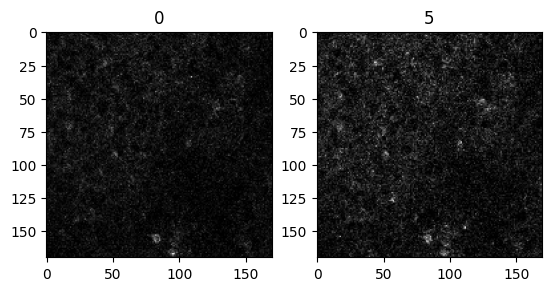

In [4]:
ind1 = 0
ind2 = 5

plt.subplot(121)
plt.imshow(movie[ind1], cmap='gray')
plt.title(ind1)

plt.subplot(122)
plt.imshow(movie[ind2], cmap='gray')
plt.title(ind2)

Plot 0th and 1000th frame side by side

Text(0.5, 1.0, '999')

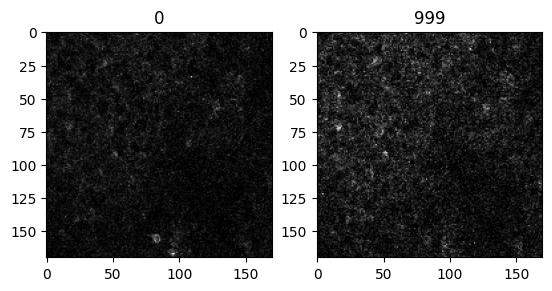

In [6]:
ind1 = 0
ind2 = 999

plt.subplot(121)
plt.imshow(movie[ind1], cmap='gray')
plt.title(ind1)

plt.subplot(122)
plt.imshow(movie[ind2], cmap='gray')
plt.title(ind2)

Plot first and last frame side by side

Text(0.5, 1.0, '-1')

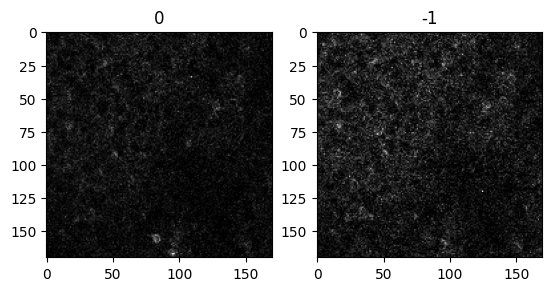

In [7]:
ind1 = 0
ind2 = -1

plt.subplot(121)
plt.imshow(movie[ind1], cmap='gray')
plt.title(ind1)

plt.subplot(122)
plt.imshow(movie[ind2], cmap='gray')
plt.title(ind2)

**Example** Plot mean projection from 0 to 100th frame and 1200 to 3000 frame side by side

Text(0.5, 1.0, '(1200:3000)')

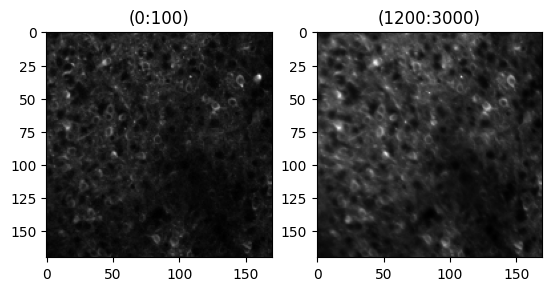

In [8]:
i1, e1 = 0, 100
i2, e2 = 1200, 3000

plt.subplot(121)
plt.imshow(movie[i1:e1 :, :].mean(axis=0), cmap='gray')
plt.title(f'({i1}:{e1})')

plt.subplot(122)
plt.imshow(movie[i2:e2 :, :].mean(axis=0), cmap='gray')
plt.title(f'({i2}:{e2})')

Plot mean projection from 500 to 1000th frame and 1500 to 3000 frame side by side

Text(0.5, 1.0, '(1500:3000)')

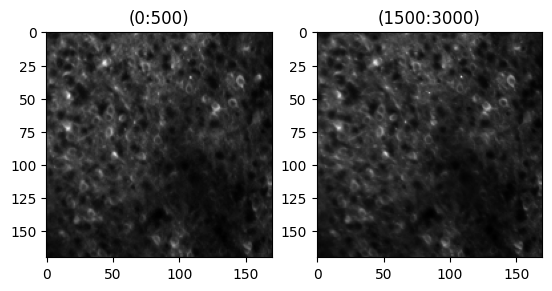

In [9]:
i1, e1 = 0, 500
i2, e2 = 1500, 3000

plt.subplot(121)
plt.imshow(movie[i1:e1 :, :].mean(axis=0), cmap='gray')
plt.title(f'({i1}:{e1})')

plt.subplot(122)
plt.imshow(movie[i2:e2 :, :].mean(axis=0), cmap='gray')
plt.title(f'({i2}:{e2})')

Plot mean projection from 100 to 500th frame and 1000 to 1500 frame side by side

Text(0.5, 1.0, '(1000:1500)')

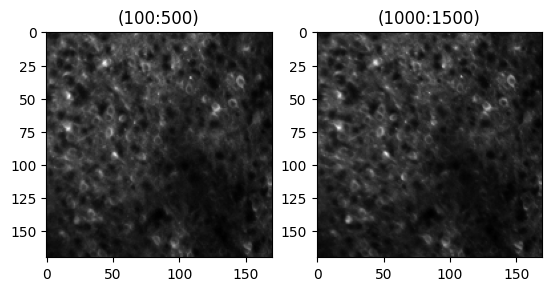

In [10]:
i1, e1 = 100, 500
i2, e2 = 1000, 1500

plt.subplot(121)
plt.imshow(movie[i1:e1 :, :].mean(axis=0), cmap='gray')
plt.title(f'({i1}:{e1})')

plt.subplot(122)
plt.imshow(movie[i2:e2 :, :].mean(axis=0), cmap='gray')
plt.title(f'({i2}:{e2})')

**Example** Make mean projection of all frames

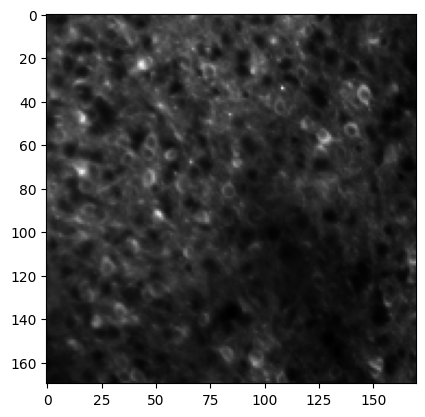

In [11]:
ref = movie.mean(axis = 0)
plt.imshow(ref, cmap='gray');

Make standard deviation projection of all the movies

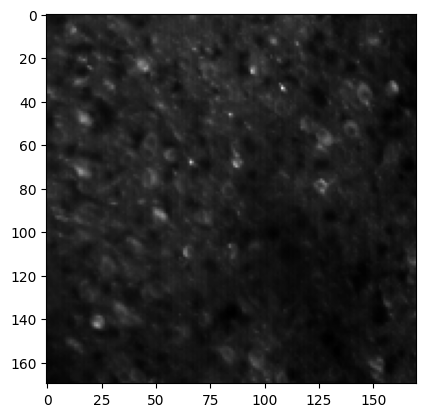

In [12]:
ref = movie.std(axis = 0)
plt.imshow(ref, cmap='gray');

Make median projection of all the movies

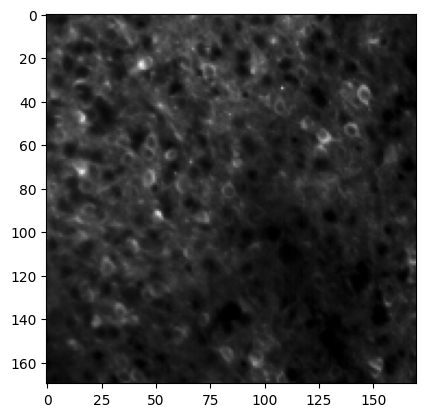

In [13]:
ref = np.median(movie, axis=0)
plt.imshow(ref, cmap='gray');

Aligning frames relies on comparing image intensities between each frame and a reference frame. So it is better to normalize frames.

**Example** Normalize and clip the frame 100 

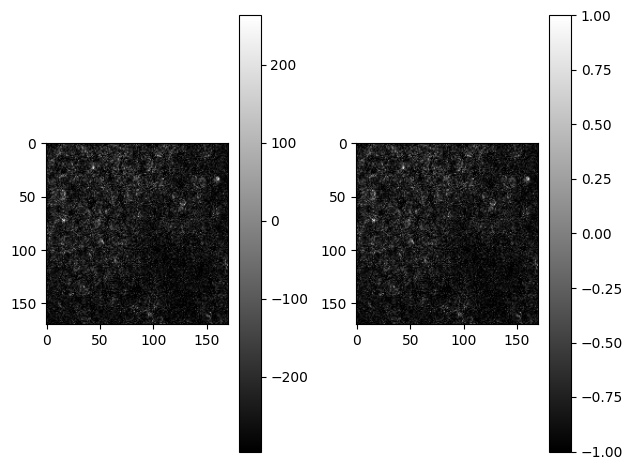

In [18]:
idx = 100
frame = movie[idx]
nrm_frame = exposure.rescale_intensity(frame)

plt.subplot(121)
plt.imshow(frame, cmap='gray')
plt.colorbar()

plt.subplot(122)
plt.imshow(nrm_frame, cmap='gray')
plt.colorbar()

plt.tight_layout()

Normalize and clip the frame 1000

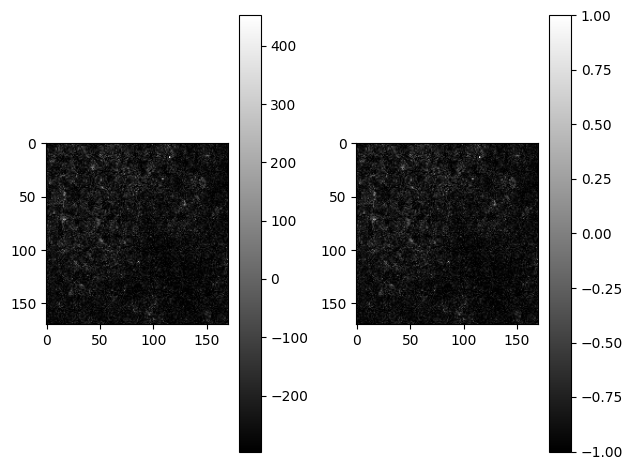

In [17]:
idx = 1000
frame = movie[idx]
nrm_frame = exposure.rescale_intensity(frame)

plt.subplot(121)
plt.imshow(frame, cmap='gray')
plt.colorbar()

plt.subplot(122)
plt.imshow(nrm_frame, cmap='gray')
plt.colorbar()

plt.tight_layout()

Normalize and clip the frame 1500

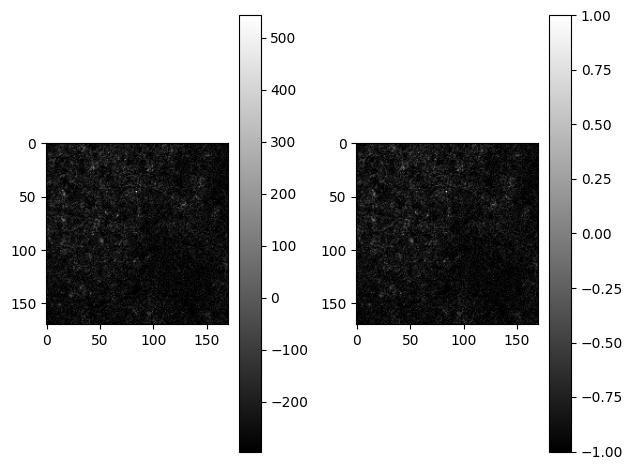

In [19]:
idx = 1500
frame = movie[idx]
nrm_frame = exposure.rescale_intensity(frame)

plt.subplot(121)
plt.imshow(frame, cmap='gray')
plt.colorbar()

plt.subplot(122)
plt.imshow(nrm_frame, cmap='gray')
plt.colorbar()

plt.tight_layout()

**Demo** Apply normalization and clipping to all frames

In [20]:
norm_movie = np.array([exposure.rescale_intensity(f) for f in movie])

### **Estimating Frame Shifts Relative to a Reference**

To correct for motion, it is necessary to know how much each frame in the movie has shifted relative to a stable reference. This section introduces the concept of shift estimation by comparing each frame to the reference image. The outcome is a set of displacement values for each frame that can be used to realign the dataset. By the end of this section, you will understand how motion is quantified and how to structure this information for use in the correction step.

Each shift is a pair of values: [dy, dx], indicating how much the image needs to move to align with the reference frame.

|                       | `dy` (Vertical Shift)     | `dx` (Horizontal Shift)   |
|-----------------------|---------------------------|---------------------------|
| **Meaning**           | Vertical movement         | Horizontal movement       |
| **Positive Value**    | Move frame **downward**   | Move frame **right**      |
| **Negative Value**    | Move frame **upward**     | Move frame **left**       |


**Example** Compute Shift Between reference and 0th frame

In [21]:
find = 0
frame = movie[find]

shift_val, _, _ = phase_cross_correlation(ref, frame)
shift_val

array([0., 0.], dtype=float32)

Compute Shift Between reference and 2800th frame

In [ ]:
find =  2800
frame = movie[find]

shift_val, _, _ = phase_cross_correlation(ref, frame)
shift_val

array([-1., -2.], dtype=float32)

Compute Shift Between reference and 2500th frame

In [ ]:
find =  2500 
frame = movie[find]

shift_val, _, _ = phase_cross_correlation(ref, frame)
shift_val

array([ 0., -1.], dtype=float32)

In [25]:
find =  2700
frame = movie[find]

shift_val, _, _ = phase_cross_correlation(ref, frame)
shift_val

array([2., 1.], dtype=float32)

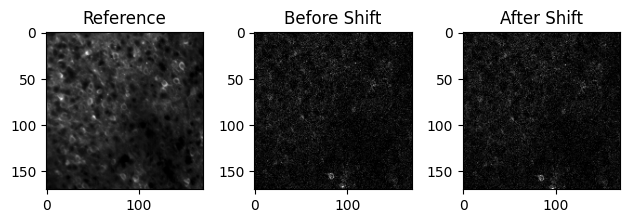

In [26]:
find =  0
frame = movie[find]
aligned = shift(frame, shift=shift_val)

plt.subplot(1, 3, 1)
plt.imshow(ref, cmap='gray')
plt.title("Reference")

plt.subplot(1, 3, 2)
plt.imshow(frame, cmap='gray')
plt.title("Before Shift")

plt.subplot(1, 3, 3)
plt.imshow(aligned, cmap='gray')
plt.title("After Shift")
plt.tight_layout()

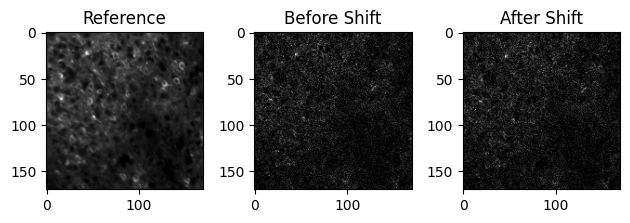

In [27]:
find =  2800
frame = movie[find]
aligned = shift(frame, shift=shift_val)

plt.subplot(1, 3, 1)
plt.imshow(ref, cmap='gray')
plt.title("Reference")

plt.subplot(1, 3, 2)
plt.imshow(frame, cmap='gray')
plt.title("Before Shift")

plt.subplot(1, 3, 3)
plt.imshow(aligned, cmap='gray')
plt.title("After Shift")
plt.tight_layout()

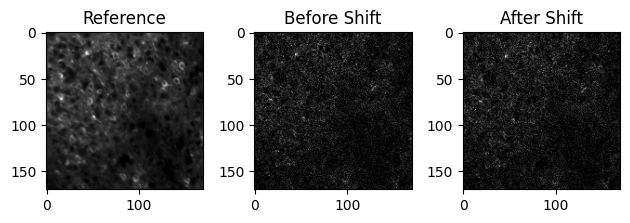

In [30]:
find =  2800
frame = movie[find]
aligned = shift(frame, shift=shift_val)

plt.subplot(1, 3, 1)
plt.imshow(ref, cmap='gray')
plt.title("Reference")

plt.subplot(1, 3, 2)
plt.imshow(frame, cmap='gray')
plt.title("Before Shift")

plt.subplot(1, 3, 3)
plt.imshow(aligned, cmap='gray')
plt.title("After Shift")
plt.tight_layout()

**Demo** Estimate shifts for all frames

In [32]:
shifts = np.array([
    phase_cross_correlation(ref, frame)[0]
    for frame in movie
])

## Motion Trace

The motion trace is a plot of frame-by-frame shifts along the X and Y directions. 

**A good trace should look have**
- small fluctuations.
- no sudden jumps between neighboring frames.

**Signs of outliers**
- sudden spike in shift (Y or X direction).
- flatline followed by a jump could suggest a movement event or an error in frame reading.
- one frame with extreme values compared to neighbors which may need to be excluded or handled separately.

**Example** Plot X shifts and spot outliers

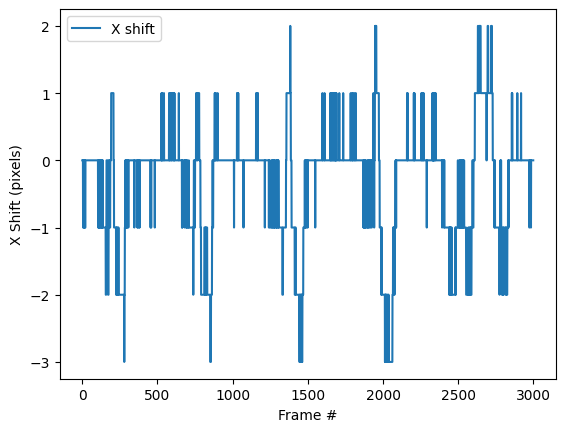

In [33]:
plt.plot(shifts[:, 1], label='X shift')
plt.xlabel("Frame #")
plt.ylabel("X Shift (pixels)")
plt.legend()

Plot Y shifts and spot outliers

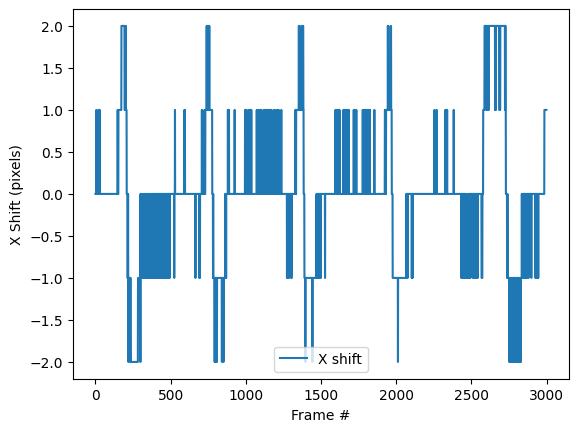

In [34]:
plt.plot(shifts[:, 0], label='X shift')
plt.xlabel("Frame #")
plt.ylabel("X Shift (pixels)")
plt.legend()

Plot both X and Y shifts

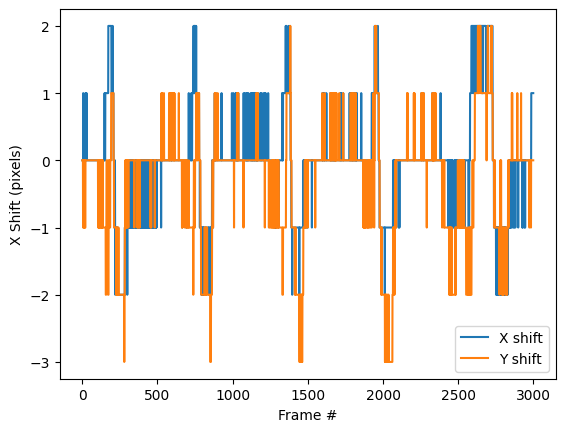

In [35]:
plt.plot(shifts[:, 0], label='X shift')
plt.plot(shifts[:, 1], label='Y shift')

plt.xlabel("Frame #")
plt.ylabel("X Shift (pixels)")
plt.legend()

### Applying Shifts to Correct Frame Alignment

After estimating the shifts, the next step is to apply them in order to correct the motion. In this section, you will learn how to realign each frame using its calculated shift while managing interpolation and boundary effects. This process generates a new motion-corrected dataset that preserves spatial consistency over time. 

**Handling borders**

| Mode        | What It Does                                                                 | Expected Plot Behavior                          |
|-------------|------------------------------------------------------------------------------|-------------------------------------------------|
| `constant`  | Pads shifted-in regions with a fixed value (default = 0)                     | Sudden **spikes or drops** in intensity at frames with large shifts |
| `nearest`   | Extends the edge of the image by repeating the closest pixel                 | **Smooth**, closely tracks the original trace   |
| `reflect`   | Mirrors pixel values from inside the image at the edges                      | **Smooth**, but with slightly more variation    |

**Example** Apply shift to all frames

In [ ]:
corrected = np.array([
    shift(f, shift=sh)
    for f, sh in zip(movie, shifts)
])

plt.subplot(121)
plt.imshow(movie.mean(axis=0), cmap='gray')
plt.title('Raw')

plt.subplot(122)
plt.imshow(corrected.mean(axis=0), cmap='gray')
plt.title('Motion Corrected')

Text(0.5, 1.0, 'Motion Corrected')

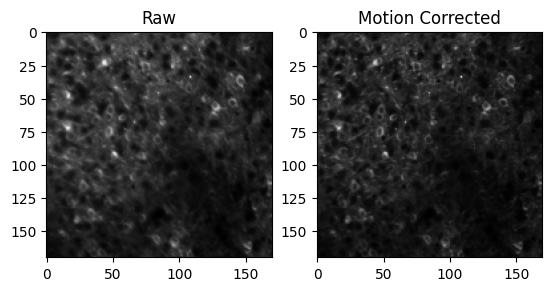

In [37]:
corrected = np.array([
    shift(f, shift=sh, mode='nearest')
    for f, sh in zip(movie, shifts)
])

plt.subplot(121)
plt.imshow(movie.mean(axis=0), cmap='gray')
plt.title('Raw')

plt.subplot(122)
plt.imshow(corrected.mean(axis=0), cmap='gray')
plt.title('Motion Corrected')

Text(0.5, 1.0, 'Motion Corrected')

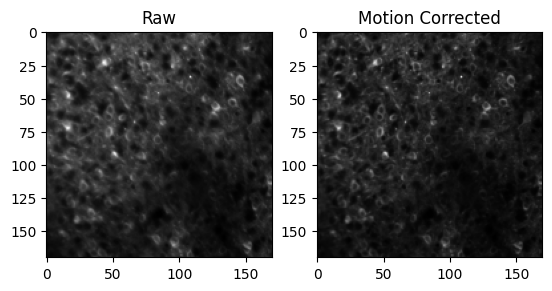

In [38]:
corrected = np.array([
    shift(f, shift=sh, mode='reflect')
    for f, sh in zip(movie, shifts)
])

plt.subplot(121)
plt.imshow(movie.mean(axis=0), cmap='gray')
plt.title('Raw')

plt.subplot(122)
plt.imshow(corrected.mean(axis=0), cmap='gray')
plt.title('Motion Corrected')

**Example** Apply constant border and compare intensity variation for top 5 pixels of original and motion corrected mean projections

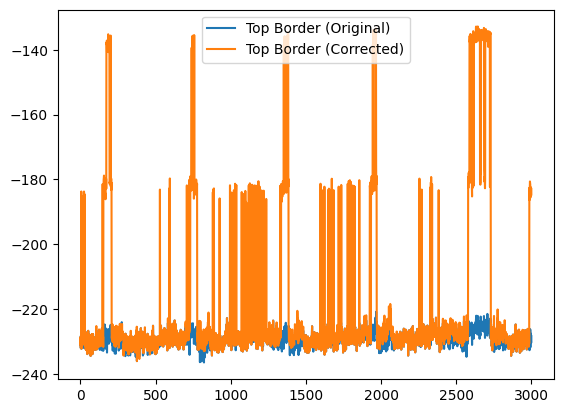

In [39]:
corrected = np.array([
    shift(f, shift=sh, mode='constant')
    for f, sh in zip(movie, shifts)
])

top_orig = np.mean(movie[:, :5, :], axis=(1, 2))
top_corr = np.mean(corrected[:, :5, :], axis=(1, 2))

plt.plot(top_orig, label='Top Border (Original)')
plt.plot(top_corr, label='Top Border (Corrected)')
plt.legend()

Apply nearest border and compare intensity variation for top 5 pixels of original and motion corrected mean projections

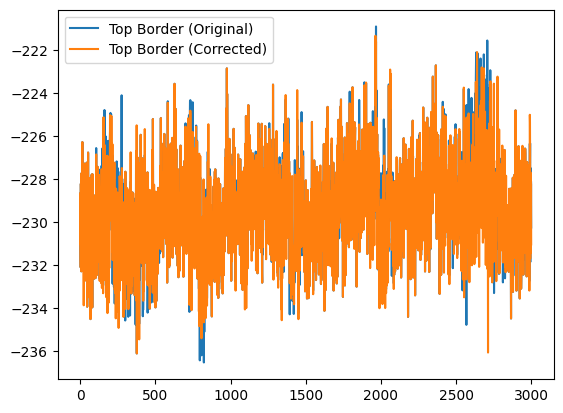

In [40]:
corrected = np.array([
    shift(f, shift=sh, mode='nearest')
    for f, sh in zip(movie, shifts)
])

top_orig = np.mean(movie[:, :5, :], axis=(1, 2))
top_corr = np.mean(corrected[:, :5, :], axis=(1, 2))

plt.plot(top_orig, label='Top Border (Original)')
plt.plot(top_corr, label='Top Border (Corrected)')
plt.legend()

Apply reflect border and compare intensity variation for top 5 pixels of original and motion corrected mean projections

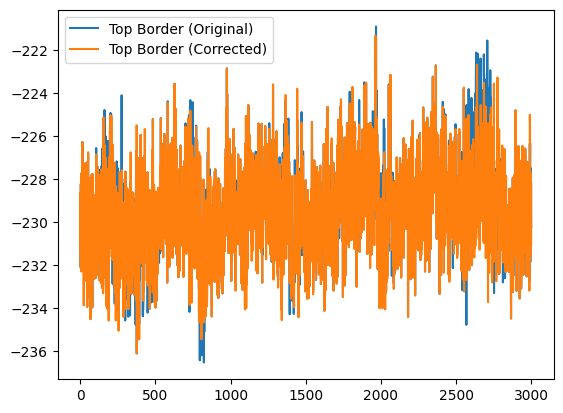

In [41]:
corrected = np.array([
    shift(f, shift=sh, mode='reflect')
    for f, sh in zip(movie, shifts)
])

top_orig = np.mean(movie[:, :5, :], axis=(1, 2))
top_corr = np.mean(corrected[:, :5, :], axis=(1, 2))

plt.plot(top_orig, label='Top Border (Original)')
plt.plot(top_corr, label='Top Border (Corrected)')
plt.legend()